In [1]:
import torch
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import torch_pruning as tp

C:\Users\derek\miniconda3\envs\cs4347\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir = "train"
val_dir = "val"

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
# Transform the training images and validatio images, add data augmentation to training (horizonal flip)
# Need to resize all images to same size
# Assume users take images directly of their skin, we choose a center crop
# Transform image to tensor
# Normalize the data according to ResNet documentation
# Did not make the images black and white, the color of the disease may be an indicator to help evaluation.
# Did add some variation in the brightness dependent on the lighting the users take pictures

transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.RandomCrop((224, 224)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(), 
    transforms.ColorJitter(brightness=0.1),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
])

transforms_val = transforms.Compose([
    transforms.Resize((224, 224)),  
     transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [5]:
train_dataset = datasets.ImageFolder(train_dir, transforms_train)
val_dataset = datasets.ImageFolder(val_dir, transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True, num_workers=0)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=12, shuffle=False, num_workers=0)

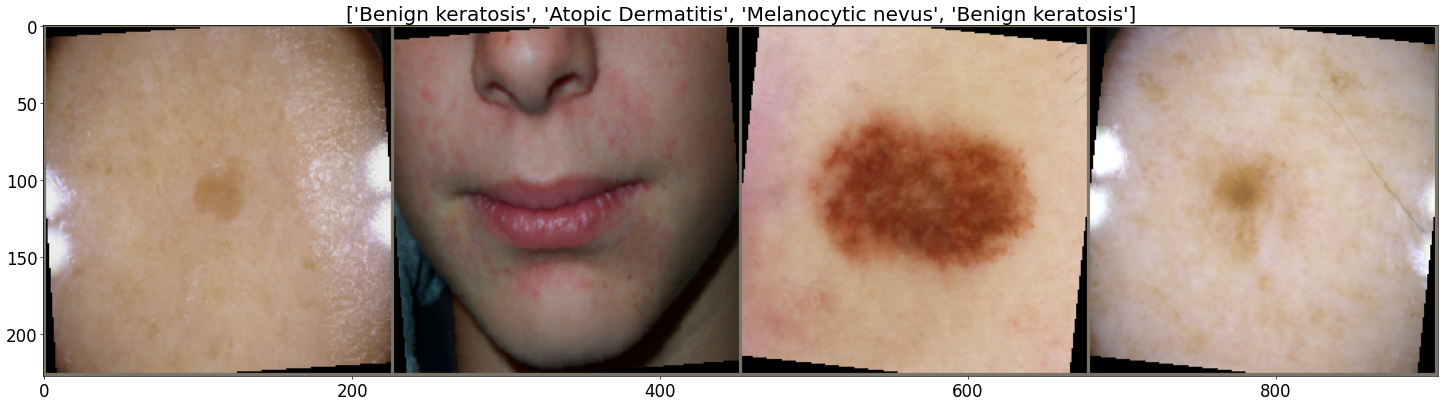

In [10]:
# View 8 different data points 

plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input, title):
    plt.figure(figsize=(30, 25)) 
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    plt.title(title)
    plt.show()

iterator = iter(train_dataloader)
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[train_dataset.classes[x] for x in classes[:4]])


In [32]:
resnet = models.resnet18(pretrained=True)

In [33]:
print(resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
base_macs, base_params = tp.utils.count_ops_and_params(resnet, example_inputs = torch.randn(1, 3, 224, 224))
print("Base MACs: %f M"%(base_macs/1e6))
print("Base Params: %f M"%(base_params/1e6))

Base MACs: 1822.177768 M
Base Params: 11.689512 M


In [35]:
num_features = resnet.fc.in_features 

In [36]:
# Add a fully-connected layer for classification
resnet.fc = torch.nn.Linear(num_features, 9)

In [37]:
# Define loss and optimizer
# AdamW has shown to perform the best for me for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet.parameters(), lr=0.0001)

In [38]:
# Train model
train_loss=[]
train_accuary=[]
val_loss=[]
val_accuary=[]

num_epochs = 15   #(set no of epochs)
start_time = time.time() #(for showing time)
# Start loop
for epoch in range(num_epochs): #(loop for every epoch)
    print("Epoch {} running".format(epoch)) #(printing message)
    """ Training Phase """
    resnet.train()    #(training model)
    running_loss = 0.   #(set loss 0)
    running_corrects = 0 
    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device) 
        # forward inputs and get output
        optimizer.zero_grad()
        outputs = resnet(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        # get loss value and update the network weights
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data).item()
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    # Append result
    train_loss.append(epoch_loss)
    train_accuary.append(epoch_acc)
    # Print progress
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time() -start_time))
    """ Testing Phase """
    resnet.eval()
    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = resnet(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            running_corrects += torch.sum(preds == labels.data).item()
        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        # Append result
        val_loss.append(epoch_loss)
        val_accuary.append(epoch_acc)
        # Print progress
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch+1, epoch_loss, epoch_acc, time.time()- start_time))

Epoch 0 running
[Train #1] Loss: 0.1044 Acc: 58.9670% Time: 166.1091s
[Validation #1] Loss: 0.0579 Acc: 74.5856% Time: 188.1419s
Epoch 1 running
[Train #2] Loss: 0.0517 Acc: 81.0617% Time: 365.1622s
[Validation #2] Loss: 0.0459 Acc: 80.1105% Time: 380.1702s
Epoch 2 running
[Train #3] Loss: 0.0346 Acc: 87.9484% Time: 544.6032s
[Validation #3] Loss: 0.0413 Acc: 82.3204% Time: 561.3518s
Epoch 3 running
[Train #4] Loss: 0.0268 Acc: 92.2525% Time: 720.7815s
[Validation #4] Loss: 0.0447 Acc: 80.6630% Time: 738.1485s
Epoch 4 running
[Train #5] Loss: 0.0186 Acc: 94.5481% Time: 922.4391s
[Validation #5] Loss: 0.0463 Acc: 85.0829% Time: 940.0044s
Epoch 5 running
[Train #6] Loss: 0.0198 Acc: 93.8307% Time: 1190.7762s
[Validation #6] Loss: 0.0635 Acc: 77.9006% Time: 1219.6102s
Epoch 6 running
[Train #7] Loss: 0.0179 Acc: 95.9828% Time: 1509.8193s
[Validation #7] Loss: 0.0461 Acc: 83.9779% Time: 1540.0586s
Epoch 7 running
[Train #8] Loss: 0.0148 Acc: 95.8393% Time: 1838.9013s
[Validation #8] Loss: 

In [39]:
import joblib

In [40]:
# Save the pruned model

joblib.dump(resnet, 'resnet-ft-skin-adamw.joblib')

['resnet-ft-skin-adamw.joblib']

In [41]:
# Save the datasets and dataloaders

torch.save({
    'train_dataset': train_dataset,
    'val_dataset': val_dataset,
    'train_dataloader': train_dataloader,
    'val_dataloader': val_dataloader
}, 'datasets_and_dataloaders.pth')